In [1]:
import numpy as np
from tensorflow.keras import layers, models
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers

In [2]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.utils import Sequence
import cv2
import matplotlib.pyplot as plt

img_size = 224

def load_data(IMAGES_PATH, annotations):
    images = []
    gaze_labels = []
    
    for index, row in annotations.iterrows():
        
            img_path = os.path.join(IMAGES_PATH, row[0])
            image = cv2.imread(img_path)
                
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = image / 255.0
            
            image_resized = cv2.resize(image, (img_size, img_size))

            images.append(image_resized)
            
            label = row[1]
            
            if label < -1:
                gaze_labels.append('left')
            elif label > 1:
                gaze_labels.append('right')
            else:
                gaze_labels.append('center')
                
            
    return np.array(images), np.array(gaze_labels)
    
annotations1 = pd.read_csv('/kaggle/input/columbia-face-and-bb-dataset/Columbia DataSet/_annotations.csv')
X, Y = load_data('/kaggle/input/columbia-face-and-bb-dataset/Columbia DataSet', annotations1)

/tmp/ipykernel_23/4269658668.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(IMAGES_PATH, row[0])
/tmp/ipykernel_23/4269658668.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]


In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

X = np.stack((X,) * 3, axis=-1)
label_encoder = LabelEncoder()
y_train_class_flat = label_encoder.fit_transform(Y.flatten())
y_train_class_encoded = to_categorical(y_train_class_flat)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y_train_class_encoded, test_size=0.3, shuffle=True, random_state=42)

In [6]:
from tensorflow.keras.applications import VGG16

vgg_face = VGG16(include_top=False, input_shape=(224, 224, 3))

vgg_face.load_weights('/kaggle/input/vgg-face-weights/tensorflow2/default/1/vgg_face_weights.h5', by_name=True)

for layer in vgg_face.layers[0:4]:
    layer.trainable = False

In [7]:
input_tensor = layers.Input(shape=(224, 224, 3))

x = vgg_face(input_tensor)

x = layers.Conv2D(64, (20, 20), activation='relu', padding='same', strides = (1,1))(x)
x = layers.Conv2D(64, (20, 20), activation='relu', padding='same', strides = (1,1))(x)
x = layers.MaxPooling2D((2, 2), padding='same',strides = (2,2))(x)

x = layers.Conv2D(128, (20, 20), activation='relu', padding='same', strides = (1,1))(x)
x = layers.Conv2D(128, (20, 20), activation='relu', padding='same', strides = (1,1))(x)
x = layers.MaxPooling2D((2, 2), padding='same', strides = (2,2))(x)

x = layers.Conv2D(256, (20, 20), activation='relu', padding='same', strides = (1,1))(x)
x = layers.Conv2D(256, (20, 20), activation='relu', padding='same', strides = (1,1))(x)
x = layers.MaxPooling2D((2, 2), padding='same', strides = (2,2))(x)

x = layers.Conv2D(256, (20, 20), activation='relu', padding='same', strides = (1,1))(x)
x = layers.Conv2D(256, (20, 20), activation='relu', padding='same', strides = (1,1))(x)
x = layers.MaxPooling2D((2, 2), padding='same', strides = (2,2))(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

classification_output = layers.Dense(3, activation='softmax', name='classification_output')(x)

final_model = models.Model(inputs=input_tensor, outputs=[classification_output])

In [8]:
final_model.compile(
    optimizer='adam',
    loss={'classification_output': 'categorical_crossentropy'},
    metrics={'classification_output': 'accuracy'}
)

final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 64)       │    13,107,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │     1,638,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 256)      │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 256)      │    26,214,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 1, 1, 256)      │    26,214,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 1, 256)      │    26,214,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_output (Dense)   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,141,571 (500.27 MB)

 Trainable params: 131,102,851 (500.12 MB)

 Non-trainable params: 38,720 (151.25 KB)

In [12]:
history = final_model.fit(
    X_train,
    {'classification_output': Y_train},
    batch_size=16,
    epochs=10,
)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 211ms/step - accuracy: 0.4292 - loss: 1.0115
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.4084 - loss: 1.0231
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.4119 - loss: 1.0202
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.4244 - loss: 1.0217
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.4285 - loss: 1.0077
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.4130 - loss: 1.0255
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.4536 - loss: 1.0084
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - accuracy: 0.4110 - loss: 1.0080
Epoch 9/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.4355 - loss: 0.9974
Epoch 10/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - accuracy: 0.4382 - loss: 1.0102


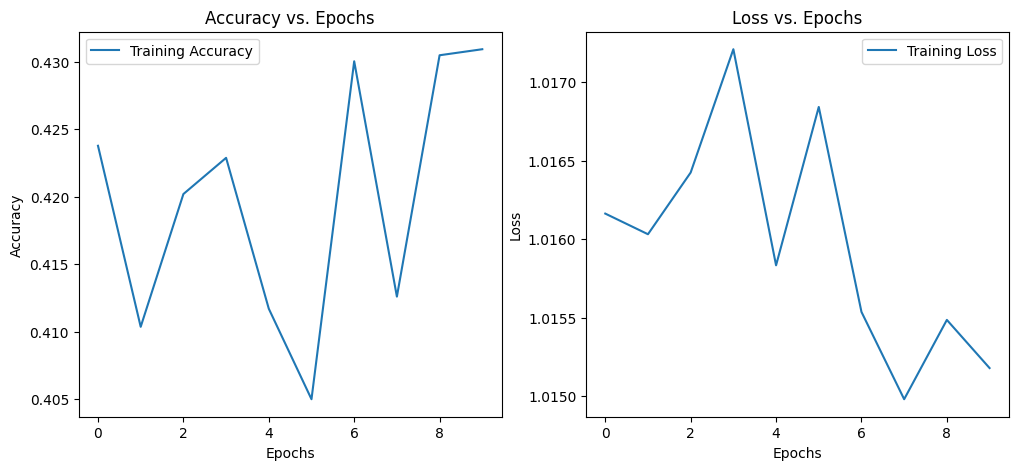

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()